In [1]:
import requests
import pandas as pd
import numpy as np 
import matplotlib.pyplot as plt
import seaborn as sb
import statsmodels.api as sm

from matplotlib import style
from statsmodels.formula.api import ols
from statsmodels.sandbox.regression.predstd import wls_prediction_std

%matplotlib inline
sb.set_style("darkgrid")

from mpl_toolkits.mplot3d import Axes3D
import matplotlib as mpl

/usr/local/lib/python3.7/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [2]:
# Importing the required modules 
import os
import sys
from bs4 import BeautifulSoup

In [11]:
NL_teams_2017 = pd.read_csv('/content/National League 2017 Results.csv', sep=',')

NL_hometeams_2017 = pd.read_csv('/content/National League 2017 Home Team Results.csv', sep =',')

In [12]:
from sklearn.metrics import f1_score, make_scorer, classification_report

scorer = make_scorer(f1_score, pos_label=None, average='weighted')

In [13]:
NL_teams_2017["HomeWin"] = NL_teams_2017["RA"] < NL_teams_2017["R"]

y_true = NL_teams_2017["HomeWin"].values

In [14]:
NL_teams_2017.head()

,Gm#,Date,Team,Unnamed: 3,Opp,W/L,R,RA,Win,Loss,Save,cLI,Streak,HomeWin
0,1,"Sunday, Apr 2",ARI,NaN,SFG,W-wo,6,5,Rodney,Melancon,NaN,1.06,+,True
1,2,"Tuesday, Apr 4",ARI,NaN,SFG,L,4,8,Cueto,Corbin,NaN,1.12,-,False
2,3,"Wednesday, Apr 5",ARI,NaN,SFG,W,8,6,Walker,Moore,Rodney,1.03,+,True
3,4,"Thursday, Apr 6",ARI,NaN,SFG,W,9,3,De La Rosa,Samardzija,NaN,1.10,++,True
4,5,"Friday, Apr 7",ARI,NaN,CLE,W,7,3,Miller,Tomlin,NaN,1.00,+++,True


In [15]:
NL_hometeams_2017.head()

,Gm#,Date,Home Team,Visitor Team,W/L,R,RA,Win,Loss,Save,cLI,Streak
0,1,"Sunday, Apr 2",ARI,SFG,W-wo,6,5,Rodney,Melancon,NaN,1.06,+
1,2,"Tuesday, Apr 4",ARI,SFG,L,4,8,Cueto,Corbin,NaN,1.12,-
2,3,"Wednesday, Apr 5",ARI,SFG,W,8,6,Walker,Moore,Rodney,1.03,+
3,4,"Thursday, Apr 6",ARI,SFG,W,9,3,De La Rosa,Samardzija,NaN,1.10,++
4,5,"Friday, Apr 7",ARI,CLE,W,7,3,Miller,Tomlin,NaN,1.00,+++


In [17]:
NL_hometeams_2017['HomeLastWin'] = np.where(NL_hometeams_2017['Streak']!= '-', True, False)
NL_hometeams_2017.head()

,Gm#,Date,Home Team,Visitor Team,W/L,R,RA,Win,Loss,Save,cLI,Streak,HomeLastWin
0,1,"Sunday, Apr 2",ARI,SFG,W-wo,6,5,Rodney,Melancon,NaN,1.06,+,True
1,2,"Tuesday, Apr 4",ARI,SFG,L,4,8,Cueto,Corbin,NaN,1.12,-,False
2,3,"Wednesday, Apr 5",ARI,SFG,W,8,6,Walker,Moore,Rodney,1.03,+,True
3,4,"Thursday, Apr 6",ARI,SFG,W,9,3,De La Rosa,Samardzija,NaN,1.10,++,True
4,5,"Friday, Apr 7",ARI,CLE,W,7,3,Miller,Tomlin,NaN,1.00,+++,True


In [8]:
n_games = NL_teams_2017["HomeWin"].count()
n_homewins = NL_teams_2017["HomeWin"].sum()
win_percentage = n_homewins / n_games

print("Home Win Percentage: {0:.1f}%".format(100 * win_percentage))

Home Win Percentage: 49.6%


In [9]:
from sklearn.metrics import f1_score
y_pred = [1] * len(y_true)

print("F1: {:.4f}".format(f1_score(y_true, y_pred, pos_label=None, average='weighted')))

F1: 0.3286


In [10]:
# Now compute the whether the home and/or vistor teams won previous game

from collections import defaultdict
won_last = defaultdict(int)

for index, row in NL_teams_2017.iterrows():
  home_team = row["Home Team"]
  visitor_team = row["Visitor Team"]
  row["HomeLastWin"] = won_last[home_team]
  row["VisitorLastWin"] = won_last[visitor_team]
  NL_teams_2017.ix[index] = row

  # Set current win
  won_last[home_team] = row["HomeWin"]
  won_last[visitor_team] = not row["HomeWin"]

KeyError: ignored

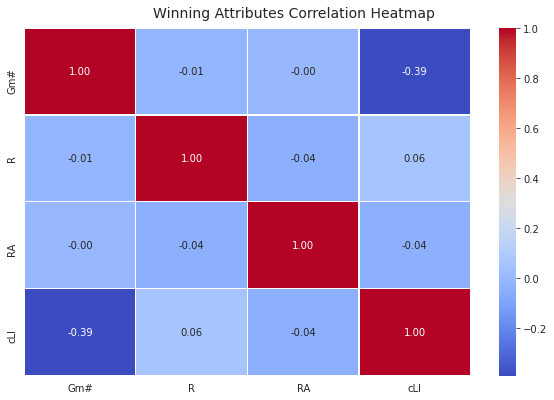

In [ ]:
# Correlation Matrix Heatmap
f, ax = plt.subplots(figsize=(10, 6))
corr = NL_teams_2017.corr()
hm = sb.heatmap(round(corr,2), annot=True, ax=ax, cmap="coolwarm",fmt='.2f',
                 linewidths=.05)
f.subplots_adjust(top=0.93)
t= f.suptitle('Winning Attributes Correlation Heatmap', fontsize=14)

In [ ]:
USER_AGENT = "Mozilla/5.0 (X11; Linux x86_64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/44.0.2403.157 Safari/537.36"
# US english
LANGUAGE = "en-US,en;q=0.5"

def get_soup(url):
    """Constructs and returns a soup using the HTML content of `url` passed"""
    # initialize a session
    session = requests.Session()
    # set the User-Agent as a regular browser
    session.headers['User-Agent'] = USER_AGENT
    # request for english content (optional)
    session.headers['Accept-Language'] = LANGUAGE
    session.headers['Content-Language'] = LANGUAGE
    # make the request
    html = session.get(url)
    # return the soup
    return bs(html.content, "html.parser")

In [ ]:
def get_all_tables(soup):
    """Extracts and returns all tables in a soup object"""
    return soup.find_all("table")

In [ ]:
def get_table_headers(table):
    """Given a table soup, returns all the headers"""
    headers = []
    for th in table.find("tr").find_all("th"):
        headers.append(th.text.strip())
    return headers

In [ ]:
def get_table_rows(table):
    """Given a table, returns all its rows"""
    rows = []
    for tr in table.find_all("tr")[1:]:
        cells = []
        # grab all td tags in this table row
        tds = tr.find_all("td")
        if len(tds) == 0:
            # if no td tags, search for th tags
            # can be found especially in wikipedia tables below the table
            ths = tr.find_all("th")
            for th in ths:
                cells.append(th.text.strip())
        else:
            # use regular td tags
            for td in tds:
                cells.append(td.text.strip())
        rows.append(cells)
    return rows

In [ ]:
def save_as_csv(table_name, headers, rows):
    pd.DataFrame(rows, columns=headers).to_csv(f"{table_name}.csv")

In [ ]:
def main(url):
    # get the soup
    soup = get_soup(url)
    # extract all the tables from the web page
    tables = get_all_tables(soup)
    print(f"[+] Found a total of {len(tables)} tables.")
    # iterate over all tables
    for i, table in enumerate(tables, start=1):
        # get the table headers
        headers = get_table_headers(table)
        # get all the rows of the table
        rows = get_table_rows(table)
        # save table as csv file
        table_name = f"table-{i}"
        print(f"[+] Saving {table_name}")
        save_as_csv(table_name, headers, rows)

In [ ]:
from bs4 import BeautifulSoup
from urllib.request import urlopen

In [ ]:
url = "view-source:https://www.baseball-reference.com/leagues/majors/2017-schedule.shtml"
page = urlopen(url)
html = page.read().decode("utf-8")
soup = BeautifulSoup(html, "html.parser")

URLError: ignored

In [ ]:
print(soup.get_text())











    (function() {
	var host = window.location.hostname;
	var element = document.createElement('script');
	var firstScript = document.getElementsByTagName('script')[0];
	var url = 'https://quantcast.mgr.consensu.org'
	    .concat('/choice/', 'XwNYEpNeFfhfr', '/', host, '/choice.js')
	var uspTries = 0;
	var uspTriesLimit = 3;
	element.async = true;
	element.type = 'text/javascript';
	element.src = url;
	
	firstScript.parentNode.insertBefore(element, firstScript);
	
	function makeStub() {
	    var TCF_LOCATOR_NAME = '__tcfapiLocator';
	    var queue = [];
	    var win = window;
	    var cmpFrame;
	    
	    function addFrame() {
		var doc = win.document;
		var otherCMP = !!(win.frames[TCF_LOCATOR_NAME]);
		
		if (!otherCMP) {
		    if (doc.body) {
			var iframe = doc.createElement('iframe');
			
			iframe.style.cssText = 'display:none';
			iframe.name = TCF_LOCATOR_NAME;
			doc.body.appendChild(iframe);
		    } else {
			setTimeout(addFrame, 5);
		    }
		}
		return !otherCMP;
	

In [ ]:
path = 'https://www.baseball-reference.com/leagues/majors/2017-schedule.shtml'

In [ ]:
# empty list
data = []

In [ ]:
# for getting the header from
# the HTML file
list_header = []
soup = BeautifulSoup(open(path),'html.parser')
header = soup.find_all("table")[0].find("tr")
  
for items in header:
    try:
        list_header.append(items.get_text())
    except:
        continue
  
# for getting the data 
HTML_data = soup.find_all("table")[0].find_all("tr")[1:]
  
for element in HTML_data:
    sub_data = []
    for sub_element in element:
        try:
            sub_data.append(sub_element.get_text())
        except:
            continue
    data.append(sub_data)

    # Storing the data into Pandas
# DataFrame 
dataFrame = pd.DataFrame(data = data, columns = list_header)
   
# Converting Pandas DataFrame
# into CSV file
dataFrame.to_csv('Geeks.csv')

FileNotFoundError: ignored

In [ ]:
MLB_teams = pd.read_csv('/content/MLB-Stats.csv', sep=',')

In [ ]:
MLB_teams.head(10)

,Team,Runs,Hits,2B,3B,HR,RBI,SB,BB,SO,BA,OBP,SLG,OPS,OPS+,Total Bases,Left On Base
0,ARI,158.0,262.0,48.0,9.0,40.0,146.0,10.0,124.0,285.0,0.237,0.320,0.405,0.725,98.0,448.0,241.0
1,ATL,145.0,237.0,49.0,3.0,45.0,140.0,8.0,111.0,276.0,0.229,0.313,0.413,0.726,91.0,427.0,201.0
2,BAL,122.0,247.0,53.0,2.0,33.0,115.0,9.0,85.0,289.0,0.230,0.289,0.376,0.665,89.0,403.0,201.0
3,BOS,172.0,298.0,75.0,3.0,39.0,156.0,15.0,95.0,271.0,0.266,0.331,0.443,0.774,116.0,496.0,215.0
4,CHC,149.0,233.0,44.0,8.0,41.0,142.0,25.0,120.0,318.0,0.226,0.315,0.403,0.719,102.0,416.0,203.0
5,CHW,146.0,250.0,45.0,4.0,26.0,135.0,17.0,115.0,267.0,0.252,0.337,0.384,0.721,107.0,381.0,216.0
6,CIN,155.0,247.0,49.0,4.0,43.0,145.0,6.0,98.0,289.0,0.243,0.321,0.426,0.747,95.0,433.0,195.0
7,CLE,127.0,208.0,46.0,6.0,40.0,121.0,16.0,102.0,262.0,0.206,0.282,0.382,0.664,85.0,386.0,176.0
8,COL,151.0,258.0,44.0,9.0,36.0,145.0,17.0,88.0,278.0,0.244,0.304,0.405,0.709,86.0,428.0,189.0
9,DET,104.0,219.0,33.0,6.0,33.0,102.0,16.0,85.0,351.0,0.207,0.268,0.343,0.611,74.0,363.0,187.0


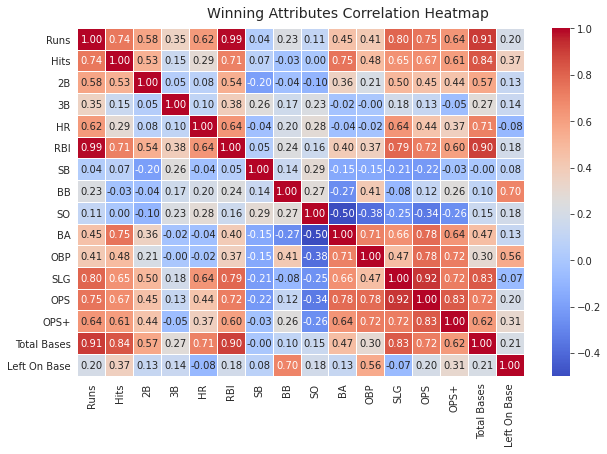

In [ ]:
# Correlation Matrix Heatmap
f, ax = plt.subplots(figsize=(10, 6))
corr = MLB_teams.corr()
hm = sb.heatmap(round(corr,2), annot=True, ax=ax, cmap="coolwarm",fmt='.2f',
                 linewidths=.05)
f.subplots_adjust(top=0.93)
t= f.suptitle('Winning Attributes Correlation Heatmap', fontsize=14)

In [ ]:
url = 'https://baseballsavant.mlb.com/league?season=2019#statcastHitting'
html = requests.get(url).content
df_list = pd.read_html(html)
df = df_list[-1]

In [ ]:
print(df)
df.to_csv('my data.csv')

      Game Date  Games    PA    AB  ...    XBA   XSLG  XWOBA  XWOBACON
0    2019-09-29     15  1140  1029  ...  0.234  0.389  0.301     0.358
1    2019-09-28     16  1212  1072  ...  0.241  0.431  0.325     0.387
2    2019-09-27     14  1112   968  ...  0.246  0.435  0.331     0.391
3    2019-09-26     11   831   752  ...  0.223  0.357  0.283     0.347
4    2019-09-25     15  1111   997  ...  0.216  0.365  0.284     0.345
..          ...    ...   ...   ...  ...    ...    ...    ...       ...
180  2019-03-30     14  1068   944  ...  0.244  0.389  0.311     0.364
181  2019-03-29      8   630   549  ...  0.227  0.415  0.316     0.371
182  2019-03-28     15  1061   953  ...  0.237  0.457  0.325     0.388
183  2019-03-21      1   103    89  ...    NaN    NaN  0.088       NaN
184  2019-03-20      1    79    66  ...    NaN    NaN  0.098       NaN

[185 rows x 26 columns]


In [ ]:
url = 'https://www.mlb.com/stats/team/2019'
html = requests.get(url).content
df_list = pd.read_html(html)
df_runs = df_list[-1]

In [ ]:
url = 'https://www.baseball-reference.com/leagues/majors/2017-schedule.shtml'
html = requests.get(url).content
df_list_2017 = pd.read_html(html)
df_runs_2017 = df_list[-1]

ValueError: ignored

In [ ]:
df_runs.head()

In [ ]:
new_df_runs = df_runs[['RR']].copy()

In [ ]:
new_df = df[['BB', 'OBP', 'WOBA']].copy()

In [ ]:
print(new_df)

In [ ]:
print (new_df[:45])

In [ ]:
print(new_df_runs)

In [ ]:
 frames = [new_df, new_df_runs]

In [ ]:
result = pd.concat(frames)

In [ ]:
print(result)

In [ ]:
style.use('seaborn-whitegrid')
plt.rcParams['figure.figsize'] = (20,10)

In [ ]:
sb.pairplot(result)
plt.savefig('pairplor.png')

In [ ]:
#invoke statsmodel's formula API using the below syntax
win_model = ols("""RR ~ WOBA + BB + OBP""", data=result).fit()
# summarize our model
win_model_summary = win_model.summary()
HTML(housing_model_summary.as_html())